In [2]:
!pip uninstall opencv-python -y -q
!pip install opencv-python==4.1.2.30 -q
!pip install albumentations --upgrade -q
!pip uninstall opencv-python -y -q
!pip install opencv-python==4.1.2.30 -q
!pip install albumentations --upgrade -q
import albumentations as A
A.__version__

'1.1.0'

In [3]:
!nvidia-smi

Thu Jun  2 12:10:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
import os
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted

In [5]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/CapstoneDataset/images_concatenate.zip -d /content/capstone_images
capstone_images = natsorted(glob(os.path.join("/content/capstone_images", '*')))

In [6]:
capstone_label_df = pd.read_csv("/content/drive/MyDrive/4-1_Capstone/CapstoneDataset/Capstone_labels.csv")

SAMPLES = 500
os.system("unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/images" + str(SAMPLES) + ".zip -d /content/aihub_images")

aihub_images = natsorted(glob(os.path.join("/content/aihub_images/images" + str(SAMPLES), '*')))
aihub_label_df = pd.read_csv("/content/aihub_images/AI_Label_" + str(SAMPLES)  +".csv")

images = capstone_images + aihub_images
label_df = pd.concat([capstone_label_df, aihub_label_df]).fillna(0.).reset_index(drop = True)

In [7]:
# train_test_split
argmax_classes = []
for label in label_df.values:
    if label.sum() == 1:    argmax_classes.append(label.argmax())
    else:                   argmax_classes.append(4) # 3과 4가 동시에 존재하면 4 데이터가 적으므로 4에 포함시킴

# len(argmax_classes)
from sklearn.model_selection import train_test_split
train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

train_images = np.array(images)[train_i]
val_images   = np.array(images)[val_i]

train_y = label_df.values[train_i]
val_y   = label_df.values[val_i]

In [8]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/gen_all.zip -d /content/gen_all

N_CLASSES = train_y.shape[1]

gen_images = os.listdir("/content/gen_all")

gen_y = [int(f.split('_')[0]) for f in gen_images]
gen_y = np.eye(N_CLASSES)[gen_y]

gen_images = [os.path.join("/content/gen_all", f) for f in gen_images]

train_images = np.concatenate([train_images, gen_images])
train_y      = np.concatenate([train_y, gen_y])

In [31]:
from torch.utils.data import Dataset
from PIL import Image
import cv2

class MyDataset(Dataset):

    def __init__(self, transform=None, split=None):        
        
        self.split = split
        self.transform = transform

        if split.upper() == 'TRAIN':
            self.img_dirs = train_images
            self.y = train_y
        
        if split.upper() == 'VALIDATION':
            self.img_dirs = val_images
            self.y = val_y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):        
        # image = Image.open(self.img_dirs[idx])
        # image = image.convert('RGB')
        # image = self.transform(image)

        image = cv2.imread(self.img_dirs[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Augment an image
        transformed = self.transform(image=image)
        image = transformed["image"]
        y = self.y[idx]

        return image, y

# import torchvision.transforms as T
!pip install timm -q
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# train_tf = T.Compose([
#     # T.Resize(256, interpolation=3),
#     # T.CenterCrop(224),
#     T.Resize(224, interpolation=3),
#     T.ToTensor(),
#     # T.RandomRotation(degrees=(-180, 180)),
#     # T.RandomHorizontalFlip(p=0.5),
#     # T.RandomVerticalFlip(p=0.5), # Rotation을 넣는 순간 Flip은 한개만 수행하면 되며, H-Flip이 V-Flip보다 빠르다.
#     # T.ColorJitter(brightness=.5, contrast=.5),
#     T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
# ])

import albumentations as A
import albumentations.pytorch as A_
train_tf = A.Compose([
    A.Resize(224, 224),
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    A_.transforms.ToTensorV2(),
])

tf = A.Compose([
    # A.Resize(224, 224),
    A.Resize(288, 288),
    A.Normalize(),
    A_.transforms.ToTensorV2(),
])

In [10]:
%cd /content/drive/MyDrive/4-1_Capstone
from utils import get_crop_mask

crop_mask = get_crop_mask()
crop_mask = torch.Tensor(crop_mask).cuda()
crop_mask

/content/drive/MyDrive/4-1_Capstone


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [11]:
%cd /content/drive/MyDrive/4-1_Capstone
from class_balanced_loss import CB_loss
from collections import Counter
samples_per_cls = list(map(float, (Counter(sorted(argmax_classes)).values())))
no_of_classes = len(label_df.columns)
loss_type = "focal" # in [sigmoid, softmax, focal]
beta = 0.9999 # usaually in 0.9, 0.99, 0.999, 0.9999
gamma = 2.0

/content/drive/MyDrive/4-1_Capstone


In [29]:
!pip install timm -q
N_CLASSES = len(label_df.columns)
import torch
import timm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torchvision
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

!pip install wandb -qqq
import wandb
wandb.login(key="9086993130a56abc5cd780b691a69c2618757f73")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calc_macro_f1(preds, GT):
    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)    
    return f1_score(GT, preds_sigmoid, average = 'macro', zero_division = 0)

# method
def train(model, epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3):
    nb_epochs = epoch

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    if      optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif    optimizer == 'RMSprop':
        optimizer = torch.optim.RMSProp(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.BCEWithLogitsLoss().to(device)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4, nb_epochs*2//4, nb_epochs*3//4], gamma=0.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)       

    train_loader = DataLoader(MyDataset(tf, split='TRAIN'),
                            batch_size=batch_size,
                            shuffle=True,
                            # drop_last=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)


    validation_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)

    import warnings
    warnings.filterwarnings('ignore')

    train_losses = []
    val_losses = []
    train_macro_f1 = []
    val_macro_f1 = []
    from tqdm import tqdm
    for epoch in tqdm(range(nb_epochs)):

        losses = 0
        preds = []                
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            H = model(X)    
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
            # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
            preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
            loss = criterion(H, Y)        
            losses += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()            
        train_loss = losses / len(train_y)
        train_losses.append(train_loss)
        
        train_f1 = calc_macro_f1(preds, train_y)
        train_macro_f1.append(train_f1)

        scheduler.step()
        # print("train_loss = ", train_loss)

        losses = 0
        preds = []                
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)

                H = model(X)
                H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
                # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
                preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
                loss = criterion(H, Y)

                losses += loss.item()
        val_loss = losses / len(val_y)
        val_losses.append(val_loss)
        # print("val_loss = ", val_loss)

        val_f1 = calc_macro_f1(preds, val_y)
        val_macro_f1.append(val_f1)

        print(f"EPOCH {epoch} : TRAIN_LOSS = {train_loss:.4f}  VAL_LOSS = {val_loss:.4f}  TRAIN_F1 = {train_f1:.3f} VAL_F1 = {val_f1:.3f}")
        # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"train-loss": train_loss, "validation-loss": val_loss, "train-f1": train_f1, "val-f1": val_f1})

    # Mark the run as finished
    wandb.finish()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_macro_f1, label='train')
    plt.plot(val_macro_f1, label='val')
    plt.title('macro_f1')
    plt.legend()

    plt.show()


def test(model, batch_size = 32):

    test_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_y, preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

def preds_analysis(preds):
    preds = np.array(preds)

    from collections import Counter
    import matplotlib.pyplot as plt
    for cls in range(len(label_df.columns)):
        plt.figure(figsize=(20,3))
        Actual_y = cls
        x = [str(n) for n in range(len(label_df.columns))]
        y = (preds[val_y[:, Actual_y] == 1] > 0).astype(int).sum(0)

        plt.bar(x, y)
        plt.title(f"Actual_y = {Actual_y}")

        for i in range(len(y)):
            plt.annotate(y[i], (x[i], y[i]), ha = 'center', va = 'bottom')

        plt.show()


def run(model = 'E', epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, memo=None):

    architecture = 'EfficientNet_B0' if model == 'E' else 'DeiT'
    # 🐝 1️⃣ Start a new run to track this script
    wandb.init(
        # Set the project where this run will be logged
        project="debug",
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name = memo, 
        # Track hyperparameters and run metadata
        config={
        "architecture": architecture,
        "epochs": epoch,
        "optimizer": optimizer,
        "learning_rate": lr,
        })
    
    from torch.nn import Linear
    N_CLASSES = 72
    if model == 'E':
        # model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
        # model.classifier = Linear(in_features=1280, out_features=N_CLASSES, bias=True)
        model = timm.create_model("efficientnetv2_rw_t", pretrained=True)
        model.classifier = Linear(in_features=1024, out_features=N_CLASSES, bias=True)

    if model == 'D':
        model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        model.head = Linear(in_features=768, out_features=N_CLASSES, bias=True)
    
    train(model, epoch, batch_size, optimizer, lr)
    preds = test(model)

wandb: Currently logged in as: bjjun970. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1. EfficientNet B0

 10%|█         | 1/10 [05:18<47:45, 318.33s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0207  TRAIN_F1 = 0.014 VAL_F1 = 0.926


 20%|██        | 2/10 [10:09<40:16, 302.12s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.948


 30%|███       | 3/10 [15:12<35:19, 302.72s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.960


 40%|████      | 4/10 [19:57<29:35, 295.89s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.951


 50%|█████     | 5/10 [24:50<24:33, 294.61s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.958


 60%|██████    | 6/10 [29:30<19:19, 289.83s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.966


 70%|███████   | 7/10 [34:12<14:21, 287.15s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.933


 80%|████████  | 8/10 [38:46<09:25, 282.94s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.955


 90%|█████████ | 9/10 [43:17<04:39, 279.32s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.962


100%|██████████| 10/10 [47:48<00:00, 286.87s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.950


train-f1,▅▆▇▁█▄▁▄▁▂
train-loss,█▃▂▄▂▁▃▂▁▃
val-f1,▁▅▇▅▇█▂▆▇▅
validation-loss,█▅▂▄▃▁▆▃▁▃
train-f1,0.01327
train-loss,0.0206
val-f1,0.9504
validation-loss,0.02061


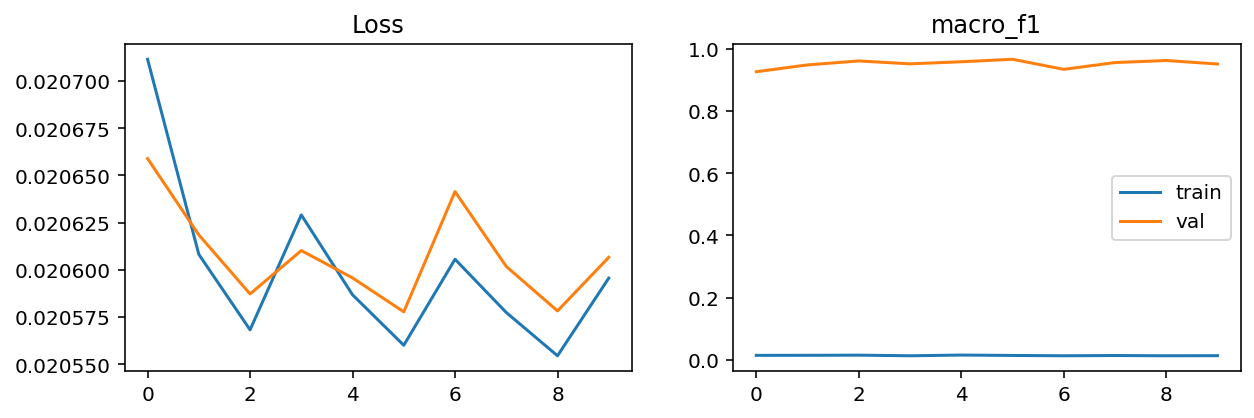

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       0.99      0.96      0.97       139
           2       0.99      0.99      0.99       311
           3       0.97      0.99      0.98       727
           4       0.84      0.75      0.80        65
           5       0.98      1.00      0.99       420
           6       0.94      0.97      0.95       273
           7       0.97      0.92      0.95       299
           8       0.97      0.97      0.97       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       0.95      0.97      0.96       283
          12       0.98      1.00      0.99       125
          13       0.99      0.99      0.99        81
          14       0.97      1.00      0.98       125
          15       0.98      0.98      0.98       125
          16       0.97      0.98      0.98       125
          17       0.98    

In [ ]:
run(model = 'E', epoch= 10, batch_size = 32, optimizer='AdamW', memo = "Augmentation")

 10%|█         | 1/10 [06:48<1:01:18, 408.73s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0207  TRAIN_F1 = 0.013 VAL_F1 = 0.932


 20%|██        | 2/10 [13:29<53:51, 403.91s/it]  

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.952


 30%|███       | 3/10 [20:09<46:55, 402.16s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.965


 40%|████      | 4/10 [26:49<40:08, 401.39s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.948


 50%|█████     | 5/10 [33:30<33:25, 401.08s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.963


 60%|██████    | 6/10 [40:09<26:42, 400.62s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.968


 70%|███████   | 7/10 [46:50<20:01, 400.59s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.956


 80%|████████  | 8/10 [53:31<13:21, 400.77s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.961


 90%|█████████ | 9/10 [1:00:12<06:40, 400.76s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.968


100%|██████████| 10/10 [1:06:54<00:00, 401.49s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.949


train-f1,▁█▂▅▇▆▆▆▃▆
train-loss,█▃▂▄▂▁▃▂▁▃
val-f1,▁▅▇▄▇█▆▇█▄
validation-loss,█▃▁▃▂▁▃▂▁▄
train-f1,0.014
train-loss,0.02058
val-f1,0.9488
validation-loss,0.02061


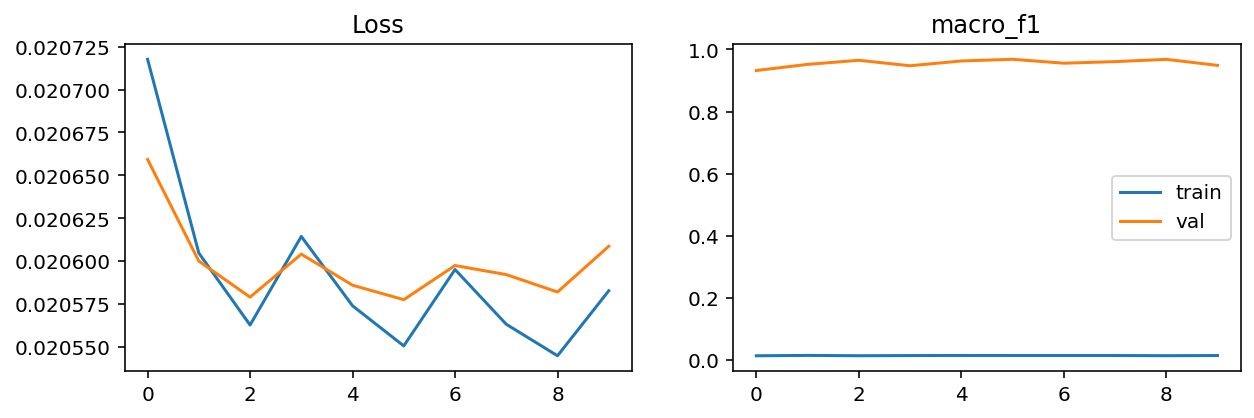

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       0.97      0.98      0.97       139
           2       1.00      0.97      0.98       311
           3       0.98      0.97      0.98       727
           4       0.82      0.83      0.82        65
           5       0.98      0.95      0.97       420
           6       0.95      1.00      0.97       273
           7       1.00      0.90      0.94       299
           8       0.95      1.00      0.97       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       0.99      0.93      0.96       283
          12       0.99      0.99      0.99       125
          13       1.00      1.00      1.00        81
          14       0.96      1.00      0.98       125
          15       0.98      0.98      0.98       125
          16       0.93      0.99      0.96       125
          17       0.97    

In [32]:
run(model = 'E', epoch= 10, batch_size = 32, optimizer='AdamW', memo = "efficientnetv2")